In [1]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence
import operator
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain_community.tools import TavilySearchResults
from dotenv import load_dotenv
import os
import logging

In [ ]:
# Set up logging
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

# Load environment variables
try:
    load_dotenv()
except Exception as e:
    logger.error(f"Failed to load environment variables: {str(e)}")
    raise EnvironmentError("Could not load environment variables. Ensure .env file is configured.")

# Initialize model, embeddings, and Tavily tool
try:
    model = ChatOpenAI(model='gpt-4o')
except Exception as e:
    logger.error(f"Failed to initialize ChatOpenAI: {str(e)}")
    raise ValueError("Failed to initialize language model. Check API key and base URL.")

try:
    #embeddings = OpenAIEmbeddings(model="models/text-embedding-004") ##This is google embedding
    embeddings = OpenAIEmbeddings(model="text-embedding-3-large") #This is OpenAI embedding
except Exception as e:
    logger.error(f"Failed to initialize embeddings: {str(e)}")
    raise ValueError("Failed to initialize embeddings. Check Google API configuration.")

try:
    tool = TavilySearchResults(api_key=os.getenv('TAVILY_API_KEY'))
except Exception as e:
    logger.error(f"Failed to initialize Tavily tool: {str(e)}")
    raise ValueError("Failed to initialize Tavily search tool. Check API key.")


### Document loading and vector store

In [3]:
try:
    loader=DirectoryLoader("../data2",glob="./*.txt",loader_cls=TextLoader)
    docs = loader.load()
    if not docs:
        raise ValueError("No documents loaded from data2 directory.")
except Exception as e:
    logger.error(f"Failed to load documents: {str(e)}")
    raise FileNotFoundError("Could not load documents from data2 directory. Ensure it exists and contains .txt files.")

try:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=200,
        chunk_overlap=50
    )
    new_docs = text_splitter.split_documents(documents=docs)
    db = Chroma.from_documents(new_docs, embeddings)
    retriever = db.as_retriever(search_kwargs={'k': 3})
except Exception as e:
    logger.error(f"Failed to create vector store: {str(e)}")
    raise ValueError("Failed to create vector store. Check document splitting or embedding process.")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [4]:
format_docs(docs)

"🇺🇸 Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP – Size, Composition, and Global Share\nAs of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks 2nd). The U.S. GDP per capita is also among the highest, hover

### Pydantic parser and agent state

In [5]:
# Pydantic parser and agent state
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description="selected topic")
    Reasoning: str = Field(description="Reasoning behind topic selection")

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [36]:
## supervisor Function Mode

In [7]:
# Supervisor node
def function_1(state: AgentState):
    try:
        question = state["messages"][-1]
        print("Question:", question)

        template = """
        Your task is to classify the given user query into one of the following categories: [USA, Web, Not Related]. 
        - Choose 'USA' if the query is related to the United States (e.g., economy, GDP, industries).
        - Choose 'Web' if the query requires real-time information from the internet (e.g., recent events, news).
        - Choose 'Not Related' for all other queries.
        Only respond with the category name and reasoning in the specified format.

        User query: {question}
        {format_instructions}
        """

        prompt = PromptTemplate(
            template=template,
            input_variables=["question"],
            partial_variables={"format_instructions": parser.get_format_instructions()}
        )

        chain = prompt | model | parser
        response = chain.invoke({"question": question})
        print("Parsed response:", response)
        return {"messages": [response.Topic]}
    except Exception as e:
        logger.error(f"Supervisor node failed: {str(e)}")
        return {"messages": ["Error: Supervisor failed to classify query."]}

In [68]:
function_1({'messages':['what are current stock market prices']})

Question: what are current stock market prices
Parsed response: Topic='Web' Reasoning="The query 'what are current stock market prices' requires real-time information from the internet as stock prices fluctuate constantly and need up-to-date data."


{'messages': ['Web']}

## Router Function

In [8]:
# Router function
def router(state: AgentState):
    print("-->Router-->")
    try:
        last_message = state["messages"][-1]
        print("last_message:", last_message)
        if "usa" in last_message.lower():
            return "RAG Call"
        elif "web" in last_message.lower():
            return "Web Call"
        else:
            return "LLM Call"
    except Exception as e:
        logger.error(f"Router failed: {str(e)}")
        raise RuntimeError(f"Router failed to determine the next node: {str(e)}")

### debugging router function

In [70]:
router({'messages':['Web']})

-->Router-->
last_message: Web


'Web Call'

## RAG Node

In [9]:
def function_2(state: AgentState):
    print("-> RAG Call ->")
    try:
        question = state["messages"][0]

        prompt = PromptTemplate(
            template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
            Question: {question}
            Context: {context}
            Answer:""",
            input_variables=['context', 'question']
        )

        rag_chain = (
            {"context": retriever | format_docs, "question": RunnablePassthrough()}
            | prompt
            | model
            | StrOutputParser()
        )
        result = rag_chain.invoke(question)
        return {"messages": [result]}
    except Exception as e:
        logger.error(f"RAG node failed: {str(e)}")
        return {"messages": ["Error: RAG node failed to generate answer."]}

## Debugging RAG Call

In [73]:
function_2({'messages':['tell me about usa gdp']})

-> RAG Call ->


{'messages': ['The U.S. GDP is the total market value of all goods and services produced in the United States and is one of the largest in the world. It is composed of various sectors including consumer spending, business investment, government spending, and net exports. The U.S. GDP plays a significant role in the global economy, influencing international markets and trade.']}

### LLM node

In [74]:

def function_3(state: AgentState):
    print("-> LLM Call ->")
    try:
        question = state["messages"][0]
        complete_query = "Answer the following question with your knowledge of the real world. Following is the user question: " + question
        response = model.invoke(complete_query)
        return {"messages": [response.content]}
    
    except Exception as e:
        print(f"Error in LLM call: {e}")
        return {"messages": [f"Sorry, I encountered an error: {str(e)}"]}

## Debugging LLM

In [76]:
function_3({'messages':['what are neural networks']})

-> LLM Call ->


{'messages': ['Neural networks are a set of algorithms modeled after the human brain, designed to recognize patterns and interpret data through a kind of machine perception, labeling, and classification. They form the foundation of deep learning algorithms. Neural networks consist of layers of interconnected nodes, or "neurons," where each connection represents a weighted link that carries information. These weights are adjusted through training to minimize error and improve accuracy in outputs.\n\n1. **Structure**: A neural network typically includes an input layer, one or more hidden layers, and an output layer. Each neuron in a layer is connected to neurons in the subsequent layer.\n\n2. **Functioning**: Information is fed into the input layer, processed through one or more hidden layers using a system of weighted "connections," and results are produced from the output layer. Neurons apply an activation function to these inputs to determine whether and to what extent information sho

### Web crawler node

In [78]:

def function_4(state: AgentState):
    print("-> Web Call ->")
    try:
        question = state["messages"][0]

        prompt = PromptTemplate(
            template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context from a web search to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
            Question: {question}
            Context: {context}
            Answer:""",
            input_variables=['context', 'question']
        )

        web_results = tool.run(question)
        context = "\n".join([result.get('content', '') for result in web_results[:3]])

        web_chain = (
            {"context": RunnableLambda(lambda x: context), "question": RunnablePassthrough()}
            | prompt
            | model
            | StrOutputParser()
        )
        result = web_chain.invoke(question)
        return {"messages": [result]}
    except Exception as e:
        logger.error(f"Web node failed: {str(e)}")
        return {"messages": ["Error: Web search failed to generate answer."]}

 ### debugging webcrawler

In [79]:
function_4({'messages':['what happened in rcb winning ceremony']})

-> Web Call ->


{'messages': ["During the RCB victory celebration, a stampede occurred outside the M Chinnaswamy Stadium in Bengaluru, resulting in the tragic death of at least 11 people and injuring over 30. The incident happened as the crowd control measures failed to manage the huge number of fans gathered to celebrate RCB's first IPL triumph. Consequently, the event was cut short, including the cancellation of a planned bus parade."]}

### Validation node

In [80]:
class ValidationParser(BaseModel):
    is_valid: bool = Field(description="Whether the answer is valid")
    reason: str = Field(description="Reason for validation result")

validation_parser = PydanticOutputParser(pydantic_object=ValidationParser)

### Validation Node

In [129]:
def function_5(state: AgentState):
    print("-> Validation Call ->")
    try:
        answer = state["messages"][-1]
        question = state["messages"][0]

        print("Question",question)
        print("Answer",answer)
        
        validation_prompt = PromptTemplate(
            template="""Validate the following answer for the given question. An answer is valid if it directly addresses the question, and is at least one sentence long. Return the result in the specified format.
            Question: {question}
            Answer: {answer}
            {format_instructions}
            """,
            input_variables=["question", "answer"],
            partial_variables={"format_instructions": validation_parser.get_format_instructions()}
        )

        validation_chain = validation_prompt | model | validation_parser
        validation_result = validation_chain.invoke({"question": question, "answer": answer})
        print("Validation result:", validation_result)
        return {"messages": [str(validation_result.is_valid)]}
    except Exception as e:
        logger.error(f"Validation node failed: {str(e)}")
        return {"messages": ["False", f"Validation failed due to error: {str(e)}"]}

### debugging validator 

In [130]:

function_5({'messages':['what happend in rcb winning ceremony','During the Royal Challengers Bengalurus (RCB) victory ceremony after their IPL triumph, a stampede occurred outside the M Chinnaswamy Stadium due to the large crowd. Tragically, at least 11 people died and over 30 were injured. The event inside the stadium was cut short, and a planned bus parade was canceled.\n']})

-> Validation Call ->
Question what happend in rcb winning ceremony
Answer During the Royal Challengers Bengalurus (RCB) victory ceremony after their IPL triumph, a stampede occurred outside the M Chinnaswamy Stadium due to the large crowd. Tragically, at least 11 people died and over 30 were injured. The event inside the stadium was cut short, and a planned bus parade was canceled.

Validation result: is_valid=True reason='The answer directly addresses the question about the events that happened during the RCB winning ceremony and provides a detailed description of the incident involving a stampede and its consequences.'


{'messages': ['True']}

## Validation Router

In [109]:

def validation_router(state: AgentState):
    print("-->Validation Router-->")
    try:
        is_valid = state["messages"][-1]  # Corrected index to access is_valid
        print("is_valid:", is_valid)
        if is_valid.lower() == "true":
            return "Accepted"
        else:
            return "Revoked"
    except Exception as e:
        logger.error(f"Validation router failed: {str(e)}")
        raise RuntimeError(f"Validation router failed to determine the next node: {str(e)}")

End State

In [142]:
def function_6(state: AgentState):
    final_answer = state['messages'][2]
    print("final_result: ",final_answer)
    print("State Messages:", state)

## Initialize Graph

In [143]:
workflow = StateGraph(AgentState)

## Add Nodes

In [144]:
workflow.add_node("Supervisor",function_1)
workflow.add_node("RAG",function_2)
workflow.add_node("LLM",function_3)
workflow.add_node("Web",function_4)
workflow.add_node("Validation",function_5)
workflow.add_node("End",function_6)

### Check Nodes

In [145]:
workflow.nodes

{'Supervisor': StateNodeSpec(runnable=Supervisor(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'RAG': StateNodeSpec(runnable=RAG(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'LLM': StateNodeSpec(runnable=LLM(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'Web': StateNodeSpec(runnable=Web(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'Validation': StateNodeSpec(runna

# Add Entry Point

In [146]:
workflow.set_entry_point("Supervisor")

## Add Conditional Edge

In [147]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "Web Call": "Web"
    }
)
  

## Add Normal Edges

In [148]:
workflow.add_edge("RAG","Validation")
workflow.add_edge("LLM","Validation")
workflow.add_edge("Web","Validation")

Add Conditional Edge

In [149]:
workflow.add_conditional_edges(
    "Validation",
    validation_router,
    {
        "Accepted": "End",
        "Revoked": "Supervisor"
    }
)

## Add End Point

In [59]:
#workflow.set_finish_point("End")

## Compile Graph

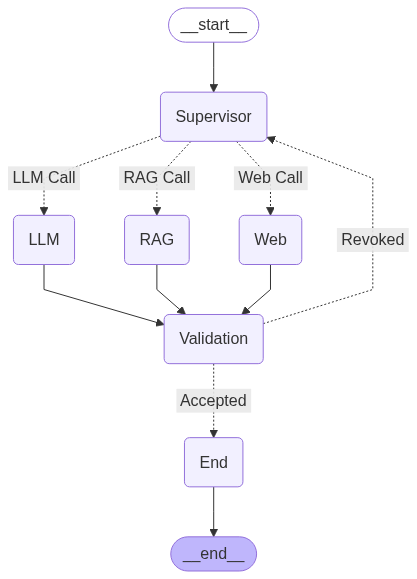

In [150]:
workflow.compile()

In [151]:
app = workflow.compile()

## Test Case 1

In [154]:

state = {"messages": ["can you tell me the industrial growth of usa?"]}
result = app.invoke(state)

Question: can you tell me the industrial growth of usa?


ERROR:__main__:Supervisor node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Router-->
last_message: Error: Supervisor failed to classify query.
-> LLM Call ->
Error in LLM call: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
-> Validation Call ->
Question can you tell me the industrial growth of usa?
Answer Sorry, I encountered an error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Validation node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Validation Router-->
is_valid: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Question: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Supervisor node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Router-->
last_message: Error: Supervisor failed to classify query.
-> LLM Call ->
Error in LLM call: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
-> Validation Call ->
Question can you tell me the industrial growth of usa?
Answer Sorry, I encountered an error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Validation node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Validation Router-->
is_valid: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Question: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Supervisor node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Router-->
last_message: Error: Supervisor failed to classify query.
-> LLM Call ->
Error in LLM call: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
-> Validation Call ->
Question can you tell me the industrial growth of usa?
Answer Sorry, I encountered an error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Validation node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Validation Router-->
is_valid: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Question: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Supervisor node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Router-->
last_message: Error: Supervisor failed to classify query.
-> LLM Call ->
Error in LLM call: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
-> Validation Call ->
Question can you tell me the industrial growth of usa?
Answer Sorry, I encountered an error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Validation node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Validation Router-->
is_valid: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Question: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Supervisor node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Router-->
last_message: Error: Supervisor failed to classify query.
-> LLM Call ->
Error in LLM call: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
-> Validation Call ->
Question can you tell me the industrial growth of usa?
Answer Sorry, I encountered an error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Validation node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Validation Router-->
is_valid: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Question: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Supervisor node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Router-->
last_message: Error: Supervisor failed to classify query.
-> LLM Call ->
Error in LLM call: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
-> Validation Call ->
Question can you tell me the industrial growth of usa?
Answer Sorry, I encountered an error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Validation node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Validation Router-->
is_valid: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Question: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Supervisor node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Router-->
last_message: Error: Supervisor failed to classify query.
-> LLM Call ->
Error in LLM call: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
-> Validation Call ->
Question can you tell me the industrial growth of usa?
Answer Sorry, I encountered an error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Validation node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Validation Router-->
is_valid: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Question: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Supervisor node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Router-->
last_message: Error: Supervisor failed to classify query.
-> LLM Call ->
Error in LLM call: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
-> Validation Call ->
Question can you tell me the industrial growth of usa?
Answer Sorry, I encountered an error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Validation node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Validation Router-->
is_valid: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Question: Validation failed due to error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ERROR:__main__:Supervisor node failed: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************mWYA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


-->Router-->
last_message: Error: Supervisor failed to classify query.


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [153]:
state = {"messages": ["can you tell me latest new about air india plane crash?"]}
result = app.invoke(state)

Question: can you tell me latest new about air india plane crash?
Parsed response: Topic='Web' Reasoning='The query asks for the latest news about an Air India plane crash, which requires real-time information from the internet to provide current updates on the event.'
-->Router-->
last_message: Web
-> Web Call ->
-> Validation Call ->
Question can you tell me latest new about air india plane crash?
Answer An Air India Boeing 787-8 Dreamliner, bound for London, crashed shortly after takeoff in Ahmedabad, India, resulting in the deaths of 241 out of the 242 people on board, with only one survivor, British national Vishwashkumar Ramesh. The crash also caused the deaths of eight local people in the residential area where the plane went down. An investigation is underway to determine the cause of the crash, and both of the aircraft's black boxes have been recovered.
Validation result: is_valid=False reason='There is no verified information about a recent Air India plane crash involving a B